# Imports

In [3]:
import sys
!{sys.executable} -m pip install sklearn
%load_ext autoreload
%matplotlib inline
%autoreload 2
import sys
import os 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams
from matplotlib.collections import LineCollection

import value_and_policy_iteration as vpi
import read_experiment_data as dd
import gridworld
import ray
import tqdm
import pickle
import random
import matplotlib
from sklearn.decomposition import PCA 
from mpl_toolkits.axes_grid1 import make_axes_locatable


ray.shutdown()
ray.init()

env = gridworld.FourRooms(p_intended=0.8)
true_r = env.get_reward_matrix()
true_p = env.get_transition_tensor()
num_states, num_actions = np.shape(true_r)
gamma = 0.99
r_max = 2
vstar, pistar = vpi.run_value_iteration(gamma, true_r, true_p, np.zeros([num_states]), threshold=1e-8, return_policy=True)
vstar = np.mean(vstar)

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{bm} \usepackage{amssymb} \usepackage[bbgreekl]{mathbbol} \DeclareSymbolFontAlphabet{\mathbb}{AMSb} \DeclareSymbolFontAlphabet{\mathbbl}{bbold} \renewcommand{\rmdefault}{ptm} \renewcommand{\sfdefault}{phv}')
cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20

  Using cached sklearn-0.0.tar.gz (1.1 kB)
  Using cached scikit_learn-0.24.2-cp38-cp38-macosx_10_13_x86_64.whl (7.2 MB)
  Using cached joblib-1.0.1-py3-none-any.whl (303 kB)
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=91e289226af82a6766ba3f205d3e6b211e522580288be064d4dd4fcd597912a8
  Stored in directory: /Users/chris/Library/Caches/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn
You should consider upgrading via the '/Users/chris/projects/model_iteration/backtester/venv/bin/python3.8 -m pip install --upgrade pip' command.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2021-06-02 13:51:34,458	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:8265


# Data loading configuration.

In [4]:
RAY_DIR = 'data/'

CAPACITY_EXPERIMENT_DIRS = ['run_experiment_2021-05-21_09-02-03']

DIAMETER_EXPERIMENT_DIRS = ['run_experiment_2021-05-23_19-33-41',
                            'run_experiment_2021-05-23_19-33-10']

# Load Capacity Experiment Data

In [6]:
experiments = {}
for exp_dir in CAPACITY_EXPERIMENT_DIRS:
    exp_data_path = os.path.expanduser(os.path.join(RAY_DIR, 'ray_capacity', exp_dir))
    experiments = {**experiments, **dd.load_data(exp_data_path, ['mean_value', 'ts'])}

dd.print_varying_fields(experiments, exclude=['seed'])
all_model_ranks = set()
for key in experiments.keys():
    all_model_ranks.add(dict(key)['model_rank'])
all_model_ranks = sorted(list(all_model_ranks))
print(all_model_ranks)
other_selections = {'env_name': 'four_rooms_rng(80)'}
do_group_by = ['ve_mode']


100%|██████████| 400/400 [00:00<00:00, 540.95it/s]


model_rank : {100, 70, 40, 104, 80, 50, 20, 90, 60, 30}
ve_mode : {(1, 'stoch'), (inf, 'det'), (inf, 'stoch'), (1, 'det')}
[20, 30, 40, 50, 60, 70, 80, 90, 100, 104]


# Display Capacity Plots

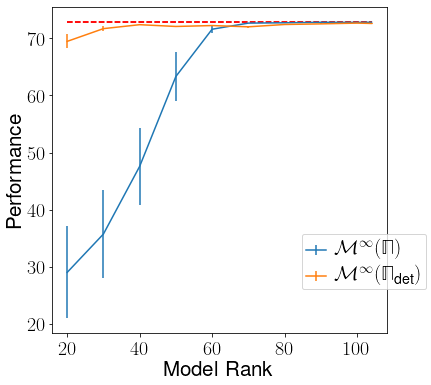

In [8]:
def grab_last_entries_means(experiments, data_name, select_by_name, select_by_list):
    all_last_entries_means, all_last_entries_stderr = [], []
    for select_by in select_by_list:
        groups = dd.select_by(experiments, **{select_by_name: select_by})
        groups = dd.group_by(groups)
        fn = lambda x: np.nan if len(x) == 0 else x[-1]
        last_entry_groups_mean = dd.map_groups(groups, lambda x: np.nanmean([fn(xx) for xx in x]))
        last_entry_groups_stderr = dd.map_groups(groups, lambda x: np.nanstd([fn(xx) for xx in x]) / np.sqrt(len(x)))
        all_last_entries_means.append(last_entry_groups_mean[()][data_name])
        all_last_entries_stderr.append(last_entry_groups_stderr[()][data_name])
    return all_last_entries_means, all_last_entries_stderr

groups = dd.select_by(experiments, **other_selections)

scale = 6
f, ax = plt.subplots(1, 1, figsize=(1*scale, 1*scale))
all_ve_modes = [
    (np.inf, 'stoch'), 
    (np.inf, 'det'),
]
ve_mode_labels = [
    r'{\huge $\mathcal{M}^\infty(\mathbbl{\Pi})$}',
    r'{\huge $\mathcal{M}^\infty(\mathbbl{\Pi}_\text{det})$}',
]

for col, ve_mode, ve_mode_label in zip(cols, all_ve_modes, ve_mode_labels):
    sub_groups = dd.select_by(groups, ve_mode=ve_mode)
    means, stderrs = grab_last_entries_means(sub_groups, 'mean_value', 'model_rank', all_model_ranks)
    ax.errorbar(x=all_model_ranks, y=means, yerr=stderrs, color=col, label=ve_mode_label)
    ax.plot(all_model_ranks, vstar * np.ones_like(all_model_ranks), '--', color='r')
ax.set_ylabel(r'{\huge $\text{Performance}$}')
ax.set_xlabel(r'{\huge $\text{Model Rank}$}')
f.legend(loc=(0.7, 0.25))
f.savefig('./visuals/model_capacity_plot.png')
f.savefig('./visuals/model_capacity_plot.pdf')


# Define Helpers for Diameter Plots

In [9]:
def get_model_vecs(x):
    x = [xx[0] for xx in x]
    all_model_vecs = []
    for path in tqdm.tqdm(x):
        model_vecs = []
        with open(path, 'rb') as f:
            model_data = pickle.load(f)
        for ts, r, p in model_data:
            model_vecs.append(np.concatenate([np.reshape(r, [-1]), np.reshape(p, [-1])], axis=0))
        model_vecs = np.array(model_vecs)
        all_model_vecs.append(model_vecs)
    return np.array(all_model_vecs)

def groupify(groups):
    return {key: [value] for key, value in groups.items()}

def ungroupify(groups):
    new_groups = dict()
    for key, value in groups.items():
        assert len(value) == 1
        new_groups[key] = value[0]
    return new_groups


def pca_model_vecs(x, c):
    x = np.array(x) # [1, num_in_group, ts, vec_size]    
    x = x[0]
    out = np.zeros([x.shape[0], x.shape[1], c])
    for i in tqdm.tqdm(range(x.shape[1])):
        pca = PCA(n_components=c).fit_transform(x[:, i, :]) # [num_in_group, c]
        out[:, i, :] = pca
    return out

@ray.remote
def get_v_parallel(r, p, true_r, true_p):
    _, model_pi = vpi.run_value_iteration(gamma, r, p, np.zeros([num_states]), return_policy=True, threshold=1e-2)
    v_model_pi = np.mean(vpi.exact_policy_evaluation(gamma, model_pi, true_r, true_p))
    return v_model_pi


def evaluate_model_vector(model_vecs_at_time, num_states, num_actions, true_r, true_p, gamma):
    res = []
    true_r_ref, true_p_ref = ray.put(true_r), ray.put(true_p)
    for model_vec in model_vecs_at_time:
        flat_r_len = np.product(np.shape(true_r))
        flat_r, flat_p = model_vec[:flat_r_len], model_vec[flat_r_len:]
        r = np.reshape(flat_r, np.shape(true_r))
        p = np.reshape(flat_p, np.shape(true_p))
        res_ref = get_v_parallel.remote(r, p, true_r_ref, true_p_ref)        
        res.append(res_ref)
    return np.array(ray.get(res))

def eval_model_vec(x):
    # x : [1, num_in_group, ts, vec_size]
    x = np.array(x)
    x = x[0]
    res = np.zeros([x.shape[0], x.shape[1]])
    for t in tqdm.tqdm(range(x.shape[1])):
        values = evaluate_model_vector(x[:, t, :], num_states, num_actions, true_r, true_p, gamma) # [num_in_group]
        res[:, t] = values
    return res
    
def get_dist_frac(x):
    x = np.array(x)
    x = x[0] # [num_in_group, ts, c]
    num_in_group, ts, c = x.shape
    prev_proj = x[:, 0, :] # [num_in_group, c]
    cum_dists = np.zeros([num_in_group, ts], dtype=np.float32)
    total_dists = np.zeros([num_in_group], dtype=np.float32)
    for t in range(ts):
        proj = x[:, t, :]
        dists = np.sum((proj - prev_proj)**2, axis=1) # [num_in_group]
        total_dists += dists
        current_dists = np.copy(total_dists)
        cum_dists[:, t] = current_dists
    cum_dists /= total_dists[:, None]
    return cum_dists
        
def make_scatter(ax, mode, pca_group, value_group, dist_group, use_dist=False, label_cb=True):
    assert mode in ['value', 'convergence']
    cmap = plt.cm.plasma
    divider = make_axes_locatable(ax)
    cb = divider.append_axes("right", size="5%", pad=0.05)
    pca_data = pca_group[0]['model_path'] # [num_in_group, ts, 2]
    value_data = value_group[0]['model_path'] # [num_in_group, ts]
    dist_data = dist_group[0]['model_path'] # [num_in_group, ts]
    max_t = pca_data.shape[1]
    for t in range(max_t):
        pca, value, dist = pca_data[:, t, :], value_data[:, t], dist_data[:, t]
        # pca, dist = pca_data[:, t, :], dist_data[:, t]
        if mode == 'convergence':
            if use_dist:
                value_colors = [cmap(x) for x in dist]
            else:
                value_colors = cmap(t / max_t)
        else:
            value_colors = [cmap(x / vstar) for x in value]
        ax.scatter(pca[:, 0], pca[:, 1], color=value_colors)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cb1 = mpl.colorbar.ColorbarBase(cb, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    if label_cb:
        if mode == 'convergence':
            cb1.set_label(r'{\huge Normalized Training Time}', rotation=270, labelpad=25)
        else:
            cb1.set_label(r'{\huge Normalized Performance}', rotation=270, labelpad=25)
        

def make_diameter_plot(ax, pca_groups, num_trials):
    value_modes = set(dict(k)['ve_mode'] for k in pca_groups.keys())
    value_modes = [n for n, pi_mode in value_modes]
    value_modes = sorted(value_modes)
    print(value_modes)
    all_diams_mean, all_diams_stderr = [], []
    for n in value_modes:
        pca = pca_groups[(('ve_mode', (n, 'det_and_stoch')),)][0]['model_path'] # [num_in_group, ts, 2]
        num_in_group = np.shape(pca)[0]
        assert num_in_group % num_trials == 0
        trial_size = num_in_group // num_trials
        trial_diams = []
        for i in range(num_trials):
            pca_part = np.array(pca)[i*trial_size:(i+1)*trial_size, :, :]
            c = np.transpose(pca_part[:, :, 0], [1, 0]) # [ts, num]
            diams = np.abs(c[:, :, None] - c[:, None, :]) # [ts, num_in_group, num_in_group]
            diams = np.max(diams, axis=1) # [ts, num_in_group]
            diams = np.max(diams, axis=1) # [ts]
            trial_diams.append(diams[-1])
        all_diams_mean.append(np.mean(trial_diams))
        all_diams_stderr.append(np.std(trial_diams) / np.sqrt(len(trial_diams)))
    ax.errorbar(np.arange(len(all_diams_mean)), y=all_diams_mean, yerr=all_diams_stderr)
    ax.scatter(np.arange(len(all_diams_mean)), all_diams_mean)
    value_modes = [r'$'+ (str(v) if v < np.inf else r'\infty') + r'$' for v in value_modes]
    #ax.set_xticklabels(['$1$'] + value_modes)
    ax.set_xticks(np.arange(len(all_diams_mean)))
    ax.set_xticklabels(value_modes)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

# Load Data for Diameter Plots

In [8]:
models, model_losses = {}, {}
for d in DIAMETER_EXPERIMENT_DIRS:
    models = {**models, **dd.load_data(os.path.join(RAY_DIR, 'ray_diameter', d), ['model_path'], no_ray=True)}

group_by = ['ve_mode']
groups = dd.group_by(models, *group_by)

#model_groups = groupify(dd.map_groups(groups, get_model_vecs))
pca_groups = groupify(dd.map_groups(model_groups, lambda x: pca_model_vecs(x, 2))) # Exp[num_in_group, ts, c]
value_groups = groupify(dd.map_groups(model_groups, eval_model_vec)) # Exp[num_in_group, ts]
dist_groups = groupify(dd.map_groups(pca_groups, get_dist_frac))


100%|██████████| 360/360 [00:59<00:00,  6.08it/s]


Going to plot  6 diagrams.
[1, 30, 40, 50, 60, inf]


TypeError: 'NoneType' object is not subscriptable

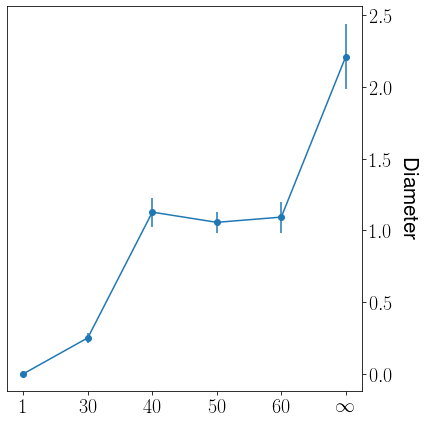

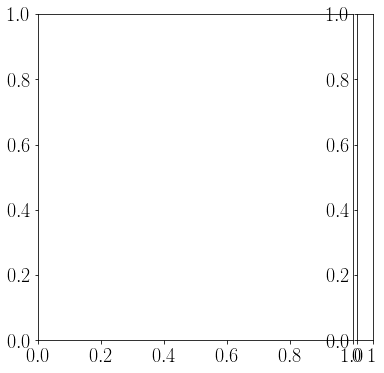

In [25]:
selection = {}
use_dist = False
print('Going to plot ', len(selected_pca_groups), 'diagrams.')


scale = 6
f, ax = plt.subplots(1, 1, figsize=(scale, scale))
make_diameter_plot(ax, selected_pca_groups, 6)
ax.set_ylabel(r'{\huge Diameter}', rotation=270, labelpad=25)
plt.tight_layout()
f.savefig('./visuals/diameter_vs_order.png')
f.savefig('./visuals/diameter_vs_order.pdf')

for key in sorted(selected_pca_groups):
    order, policy_type = dict(key)['ve_mode']
    f, ax = plt.subplots(1, 1, figsize=(scale, scale))
    make_scatter(ax, 'convergence',
                 pca_groups[key], value_groups[key], dist_groups[key],
                 use_dist=False, label_cb=(order == np.inf))
    # ax.set_title()
    order_str = str(order) if order < np.inf else r'\infty'
    ax.set_title(r'{\huge Order $\bm{' + order_str + '}$}')
    plt.tight_layout()
    f.savefig(f'./visuals/conv_{order}.png')
    f.savefig(f'./visuals/conv_{order}.pdf')
    f, ax = plt.subplots(1, 1, figsize=(scale, scale))
    make_scatter(ax, 'value',
                 pca_groups[key], value_groups[key], dist_groups[key],
                 use_dist=False, label_cb=(order == np.inf))
    plt.tight_layout()
    f.savefig(f'./visuals/perf_{order}.png')
    f.savefig(f'./visuals/perf_{order}.pdf')

In [ ]:
from matplotlib.collections import LineCollection


def set_tickless(ax):  
    ax.tick_params(
        axis='x',          
        which='both',      
        bottom=False,      
        top=False,         
        labelbottom=False) 
    ax.tick_params(
        axis='y',          
        which='both',      
        left=False,        
        right=False,       
        labelleft=False)

def get_one_with_key(key, idx=0):
    model_vec = np.array(model_groups[key][0]['model_path'][idx][-1])
    return model_vec

def get_model_from_vector(vector):
    flat_r_len = np.product(np.shape(true_r))
    flat_r, flat_p = vector[:flat_r_len], vector[flat_r_len:]
    r = np.reshape(flat_r, np.shape(true_r))
    p = np.reshape(flat_p, np.shape(true_p))
    return r, p

fpve_key = (('ve_mode', (np.inf, 'det_and_stoch')),)
fpve_model_vec = get_one_with_key(fpve_key, 0)
fpve_model = get_model_from_vector(fpve_model_vec)

ve_key = (('ve_mode', (1, 'det_and_stoch')),)
ve_model_vec = get_one_with_key(ve_key, 0)
ve_model = get_model_from_vector(ve_model_vec)


    

def visualize_trajs(ax, start_pos, model, env, pi, num_trajs=100, traj_len=100):
    r, p = model
    num_states, num_actions = r.shape
    ppi = np.sum(pi[:, :, None] * p, axis=1) # [s, s]
    ppi = ppi / np.sum(ppi, axis=1)[:, None]
    rpi = np.sum(r * pi, axis=1)
    all_traj = []
    for _ in tqdm.tqdm(range(num_trajs)):
        traj = []
        pos = start_pos
        s = env._free_tile_mapping[pos]
        traj.append(pos)
        for _ in range(traj_len-1):
            s = np.random.choice(num_states, p=ppi[s, :])
            pos = env._s_to_xy[s]
            traj.append(pos)
        all_traj.append(traj)
    cmap = colors.ListedColormap(['white', 'gray', 'red', 'green'])
    bounds = [0,1,2,3]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    im = ax.imshow(env.visualize(), cmap=cmap, norm=norm)
    
    traj_cmap = cm.get_cmap('plasma')
    
    for traj in tqdm.tqdm(all_traj):
        traj = np.array(traj)
        xs, ys = zip(*traj)
        perc = (np.arange(len(xs), dtype=np.float32) + 1) / len(xs)
        lc = LineCollection(zip(traj[:-1], traj[1:]), array=perc, cmap=plt.cm.plasma, alpha=0.02)
        ax.add_collection(lc)
        ax.margins(0.1)
        #ax.plot(xs, ys, c=perc, cmap=traj_cmap)
    set_tickless(ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(lc, cax=cax)
    cb.set_label(r'{\huge Normalized Trajectory Time}', rotation=270, labelpad=25)
    cb.solids.set(alpha=1.0)
    ax.scatter([start_pos[0]], [start_pos[1]], c='r', s=150)
        
    
    
model = fpve_model    
_, pi = vpi.run_value_iteration(
    gamma, env.get_reward_matrix(), env.get_transition_tensor(), np.zeros([num_states]), return_policy=True)
scale = 6
#pi = 0.2 * (np.ones_like(pi) / num_actions) + 0.8 * pi
f, ax = plt.subplots(1, 1, figsize=(scale, scale))
true_model = (env.get_reward_matrix(), env.get_transition_tensor())
visualize_trajs(ax, (1, 11), true_model, env, pi, num_trajs=5000, traj_len=30)
ax.set_title(r'{\huge Environment}')
plt.tight_layout()
f.savefig('./visuals/opt_traj_environment.png')
f.savefig('./visuals/opt_traj_environment.pdf')

f, ax = plt.subplots(1, 1, figsize=(scale, scale))
true_model = (env.get_reward_matrix(), env.get_transition_tensor())
visualize_trajs(ax, (1, 11), fpve_model, env, pi, num_trajs=5000, traj_len=30)
ax.set_title(r'{\huge PVE Model}')
plt.tight_layout()
f.savefig('./visuals/opt_traj_pve.png')
f.savefig('./visuals/opt_traj_pve.pdf')